In [109]:
import csv
import datetime
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import xgboost as xgb
import math

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

## XGBoost Model

In [95]:
def build_xgboost_model(X_train, y_train, params):
    """
    Return: xgboost model
    """
    model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        max_depth=params['max_depth'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        verbosity=params['verbosity']
        
    )
    return model.fit(X_train, y_train)

In [96]:
def prediction(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [97]:
def get_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

## Predict Trip Duration

In [19]:
def read_from_csv(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [91]:
train_path = './data/train.csv'
test_path = './data/test.csv'

X_train, X_test = read_from_csv(train_path, ), read_from_csv(test_path)
len(X_train), len(X_test)

(956868, 239217)

In [92]:
y_train, y_test = pd.DataFrame(X_train['duration']), pd.DataFrame(X_test['duration'])

X_train.drop(columns=['duration'], inplace=True)
X_test.drop(columns=['duration'], inplace=True)

# drop the datetime type columns
X_train.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'], inplace=True)
X_test.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'], inplace=True)

In [105]:
params = { 
    'booster': 'gbtree',
    'objective':'reg:squarederror',
    'learning_rate': 0.2,
    'n_estimators': 200,
    'gamma': 0.3,                  # control pruning
    'max_depth':5 ,               
    'lambda': 2,                   # L2 parameter
    'subsample': 0.8,              # random sample 
    'colsample_bytree': 0.7,       # col sample when generate tree
    'min_child_weight': 1,
    'reg_alpha': 0,
    'verbosity':1
}

In [99]:
model = build_xgboost_model(X_train, y_train, params)

[22:10:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [100]:
# Train
y_pred = prediction(model, X_train)

train_loss = get_rmse(y_train, y_pred)
print("Train Loss: {}".format(train_loss))

Train Loss: 1.4535075544962008


In [101]:
# Test
y_pred = prediction(model, X_test)

test_loss = get_rmse(y_test, y_pred)
print("Test Loss: {}".format(test_loss))

Test Loss: 1.4673157355837458


## Grid Search 

In [ ]:
# A parameter grid for XGBoost
# params = { 
#     'booster': 'gbtree',
#     'objective':'reg:squarederror',
#     'learning_rate': 0.2,
#     'n_estimators': 200,  
#     'gamma': 0.3,                  # control pruning
#     'max_depth':5 ,               
#     'lambda': 2,                   # L2 parameter
#     'subsample': 0.8,              # random sample 
#     'colsample_bytree': 0.7,       # col sample when generate tree
#     'min_child_weight': 1,
#     'reg_alpha': 0,
#     'verbosity':1
# }

params = {
        'booster': 'gbtree',
        'objective':'reg:squarederror',
        'max_depth': 5,
        'lambda': 2,                   # L2 parameter
        'subsample': 0.8,              # random sample 
        'colsample_bytree': 0.7,       # col sample when generate tree
        'min_child_weight': 1,
        'reg_alpha': 0,
        'verbosity':1
        }
search_params={
        'learning_rate': [0.1, 0.2, 0.3],
        'n_estimators': [100, 200, 300], 
        'gamma': [0.5, 1, 1.5, 2, 5],
}

model = xgb.XGBRegressor(
        booster=params['booster'],
        objective=params['objective'],
        n_jobs=-1,
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=0,
        max_depth=params['max_depth'],
        min_child_weight=params['min_child_weight'],
        reg_alpha=params['reg_alpha'],
        verbosity=params['verbosity']
    )

# folds = 3
# param_comb = 3

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

# random_search = RandomizedSearchCV(model, 
#                                    param_distributions=search_params, 
#                                    n_iter=param_comb, 
#                                    n_jobs=-1, 
#                                    cv=skf.split(X_train,y_train), 
#                                    verbose=3, 
#                                    random_state=1001,
                                    
#                                   )

# # Here we go
# random_search.fit(X_train, y_train)
gs = GridSearchCV(model, search_params, scoring="neg_mean_absolute_error", cv=5, verbose=2)
gs.fit(X_train, y_train)
print(gs.grid_scores_, gs.best_params_, gs.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total= 1.6min
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] ... gamma=0.5, learning_rate=0.1, n_estimators=100, total= 1.2min
[CV] gamma=0.5, learning_rate=0.1, n_estimators=100 ..................


## Feature Importance

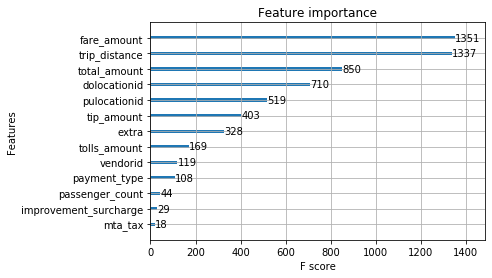

In [103]:
xgb.plot_importance(model, importance_type = 'weight')